# Proyecto: Accidentes de tráfico

### Step 1: Problem definition

- Predicción de la gravedad de los accidentes con relación a factores ambientales, humanos y el estado de la vía.
- 


### Step 2: Acquiring and loading the data set

In [19]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

In [20]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version
data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "oktayrdeki/traffic-accidents",
  "traffic_accidents.csv"
)

print("First 5 records:", data.head())

/tmp/ipykernel_625/2972283283.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  data = kagglehub.load_dataset(


First 5 records:                crash_date traffic_control_device weather_condition  \
0  07/29/2023 01:00:00 PM         TRAFFIC SIGNAL             CLEAR   
1  08/13/2023 12:11:00 AM         TRAFFIC SIGNAL             CLEAR   
2  12/09/2021 10:30:00 AM         TRAFFIC SIGNAL             CLEAR   
3  08/09/2023 07:55:00 PM         TRAFFIC SIGNAL             CLEAR   
4  08/19/2023 02:55:00 PM         TRAFFIC SIGNAL             CLEAR   

       lighting_condition first_crash_type trafficway_type  \
0                DAYLIGHT          TURNING     NOT DIVIDED   
1  DARKNESS, LIGHTED ROAD          TURNING        FOUR WAY   
2                DAYLIGHT         REAR END  T-INTERSECTION   
3                DAYLIGHT            ANGLE        FOUR WAY   
4                DAYLIGHT         REAR END  T-INTERSECTION   

            alignment roadway_surface_cond road_defect  \
0  STRAIGHT AND LEVEL              UNKNOWN     UNKNOWN   
1  STRAIGHT AND LEVEL                  DRY  NO DEFECTS   
2  STRAIGHT AND

### Step 3: Store the information

Cambiar la forma de guardar los datos en la bd (hacerlo con script)

In [21]:
import sqlite3

#Creación de la db y tablas con datos

con = sqlite3.connect("../data/project_db.db")
data.to_sql('accident', con, if_exists='replace', index=False)

209306

### Step 4: Perform a descriptive analysis

In [22]:
data.describe()

,num_units,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
count,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000,209306.000000
mean,2.063300,0.382717,0.001859,0.038102,0.221241,0.121516,2.244002,13.373047,4.144024,6.771822
std,0.396012,0.799720,0.047502,0.233964,0.614960,0.450865,1.241175,5.603830,1.966864,3.427593
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,2.000000,4.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.000000,4.000000,7.000000
75%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,17.000000,6.000000,10.000000
max,11.000000,21.000000,3.000000,7.000000,21.000000,15.000000,49.000000,23.000000,7.000000,12.000000


### Step 5: Perform a full EDA

In [23]:
# Obtain dimensions
data.shape

(209306, 24)

El dataset contiene un total de 209306 registros cuyos atributos se distribuyen en 24 columnas

In [24]:
# Obtain information about data types and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

- Hay un total de 209306 registros
- 10 variables son de tipo numérico, y 14 son categóricas.
- No se detectó ningún registro con columnas nulas.


In [25]:
if data.duplicated().sum():
    print("Duplicados encontrados: ",data.duplicated().sum())
    total_data = data.drop_duplicates()
print(total_data.shape)
total_data.head()

Duplicados encontrados:  31
(209275, 24)


,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [26]:
data.drop(["crash_date", "first_crash_type", "damage", "injuries_total"], axis = 1, inplace = True)
data.head()

,traffic_control_device,weather_condition,lighting_condition,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,intersection_related_i,prim_contributory_cause,num_units,most_severe_injury,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,Y,UNABLE TO DETERMINE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,13,7,7
1,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,IMPROPER TURNING/NO SIGNAL,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,2.0,0,1,8
2,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,Y,FOLLOWING TOO CLOSELY,3,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,10,5,12
3,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,Y,UNABLE TO DETERMINE,2,NONINCAPACITATING INJURY,0.0,0.0,5.0,0.0,0.0,19,4,8
4,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,Y,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,3.0,14,7,8


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   traffic_control_device         209306 non-null  object 
 1   weather_condition              209306 non-null  object 
 2   lighting_condition             209306 non-null  object 
 3   trafficway_type                209306 non-null  object 
 4   alignment                      209306 non-null  object 
 5   roadway_surface_cond           209306 non-null  object 
 6   road_defect                    209306 non-null  object 
 7   crash_type                     209306 non-null  object 
 8   intersection_related_i         209306 non-null  object 
 9   prim_contributory_cause        209306 non-null  object 
 10  num_units                      209306 non-null  int64  
 11  most_severe_injury             209306 non-null  object 
 12  injuries_fatal                

- Hay un total de 209306 cuyos atributos se encuentran distribuidos en 20 columnas.
- 9 variables se consideran numéricas debido a que sus atributos sirven para contabilizar.
- 11 variables son categóricas.

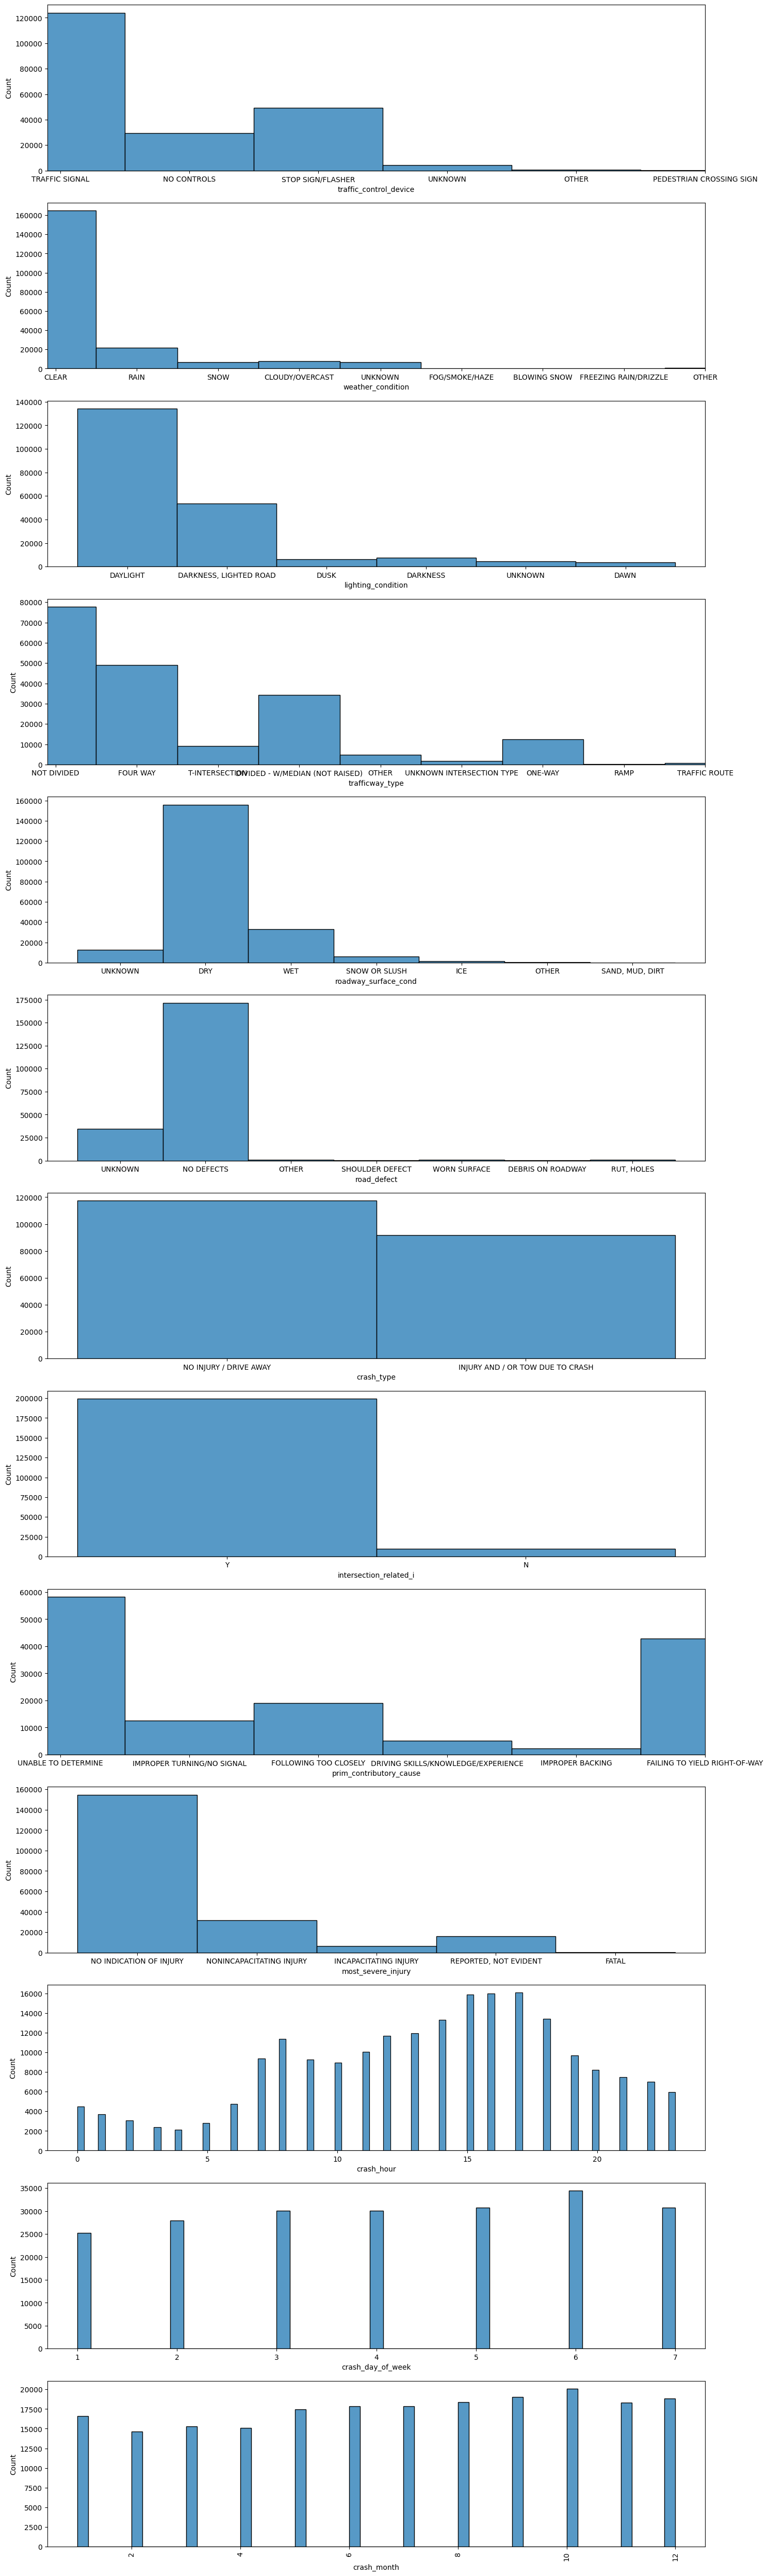

In [28]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, axis = plt.subplots(13, figsize = (15, 50))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = data, x = "traffic_control_device").set_xlim(-0.1, 5)
sns.histplot(ax = axis[1], data = data, x = "weather_condition").set_xlim(-0.1, 8)
sns.histplot(ax = axis[2], data = data, x = "lighting_condition")
sns.histplot(ax = axis[3], data = data, x = "trafficway_type").set_xlim(-0.1, 8)
sns.histplot(ax = axis[4], data = data, x = "roadway_surface_cond")
sns.histplot(ax = axis[5], data = data, x = "road_defect")
sns.histplot(ax = axis[6], data = data, x = "crash_type")
sns.histplot(ax = axis[7], data = data, x = "intersection_related_i")
sns.histplot(ax = axis[8], data = data, x = "prim_contributory_cause").set_xlim(-0.1, 5)
sns.histplot(ax = axis[9], data = data, x = "most_severe_injury")
sns.histplot(ax = axis[10], data = data, x = "crash_hour")
sns.histplot(ax = axis[11], data = data, x = "crash_day_of_week")
sns.histplot(ax = axis[12], data = data, x = "crash_month")


# Adjust the layout
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

- Cuando las condiciones climáticas y de carretera son optimas, el riesgo de accidente vial aumenta debido al factor humano de forma significativa.
- Existen más accidentes de tráfico en vialidades donde hay semáforos
- La mayoría de los accidentes es causado por factores humanos, tal como se concluyó anteriormente
- No hubieron heridos reportados en la mayor parte de los accidentes registrados.
- De 3 a 5 pm existe una mayor probabilidad de que ocurra un accidente
- Los viernes son más propensos a accidentes
- Octubre es el mes con el mayor número de accidentes registrados

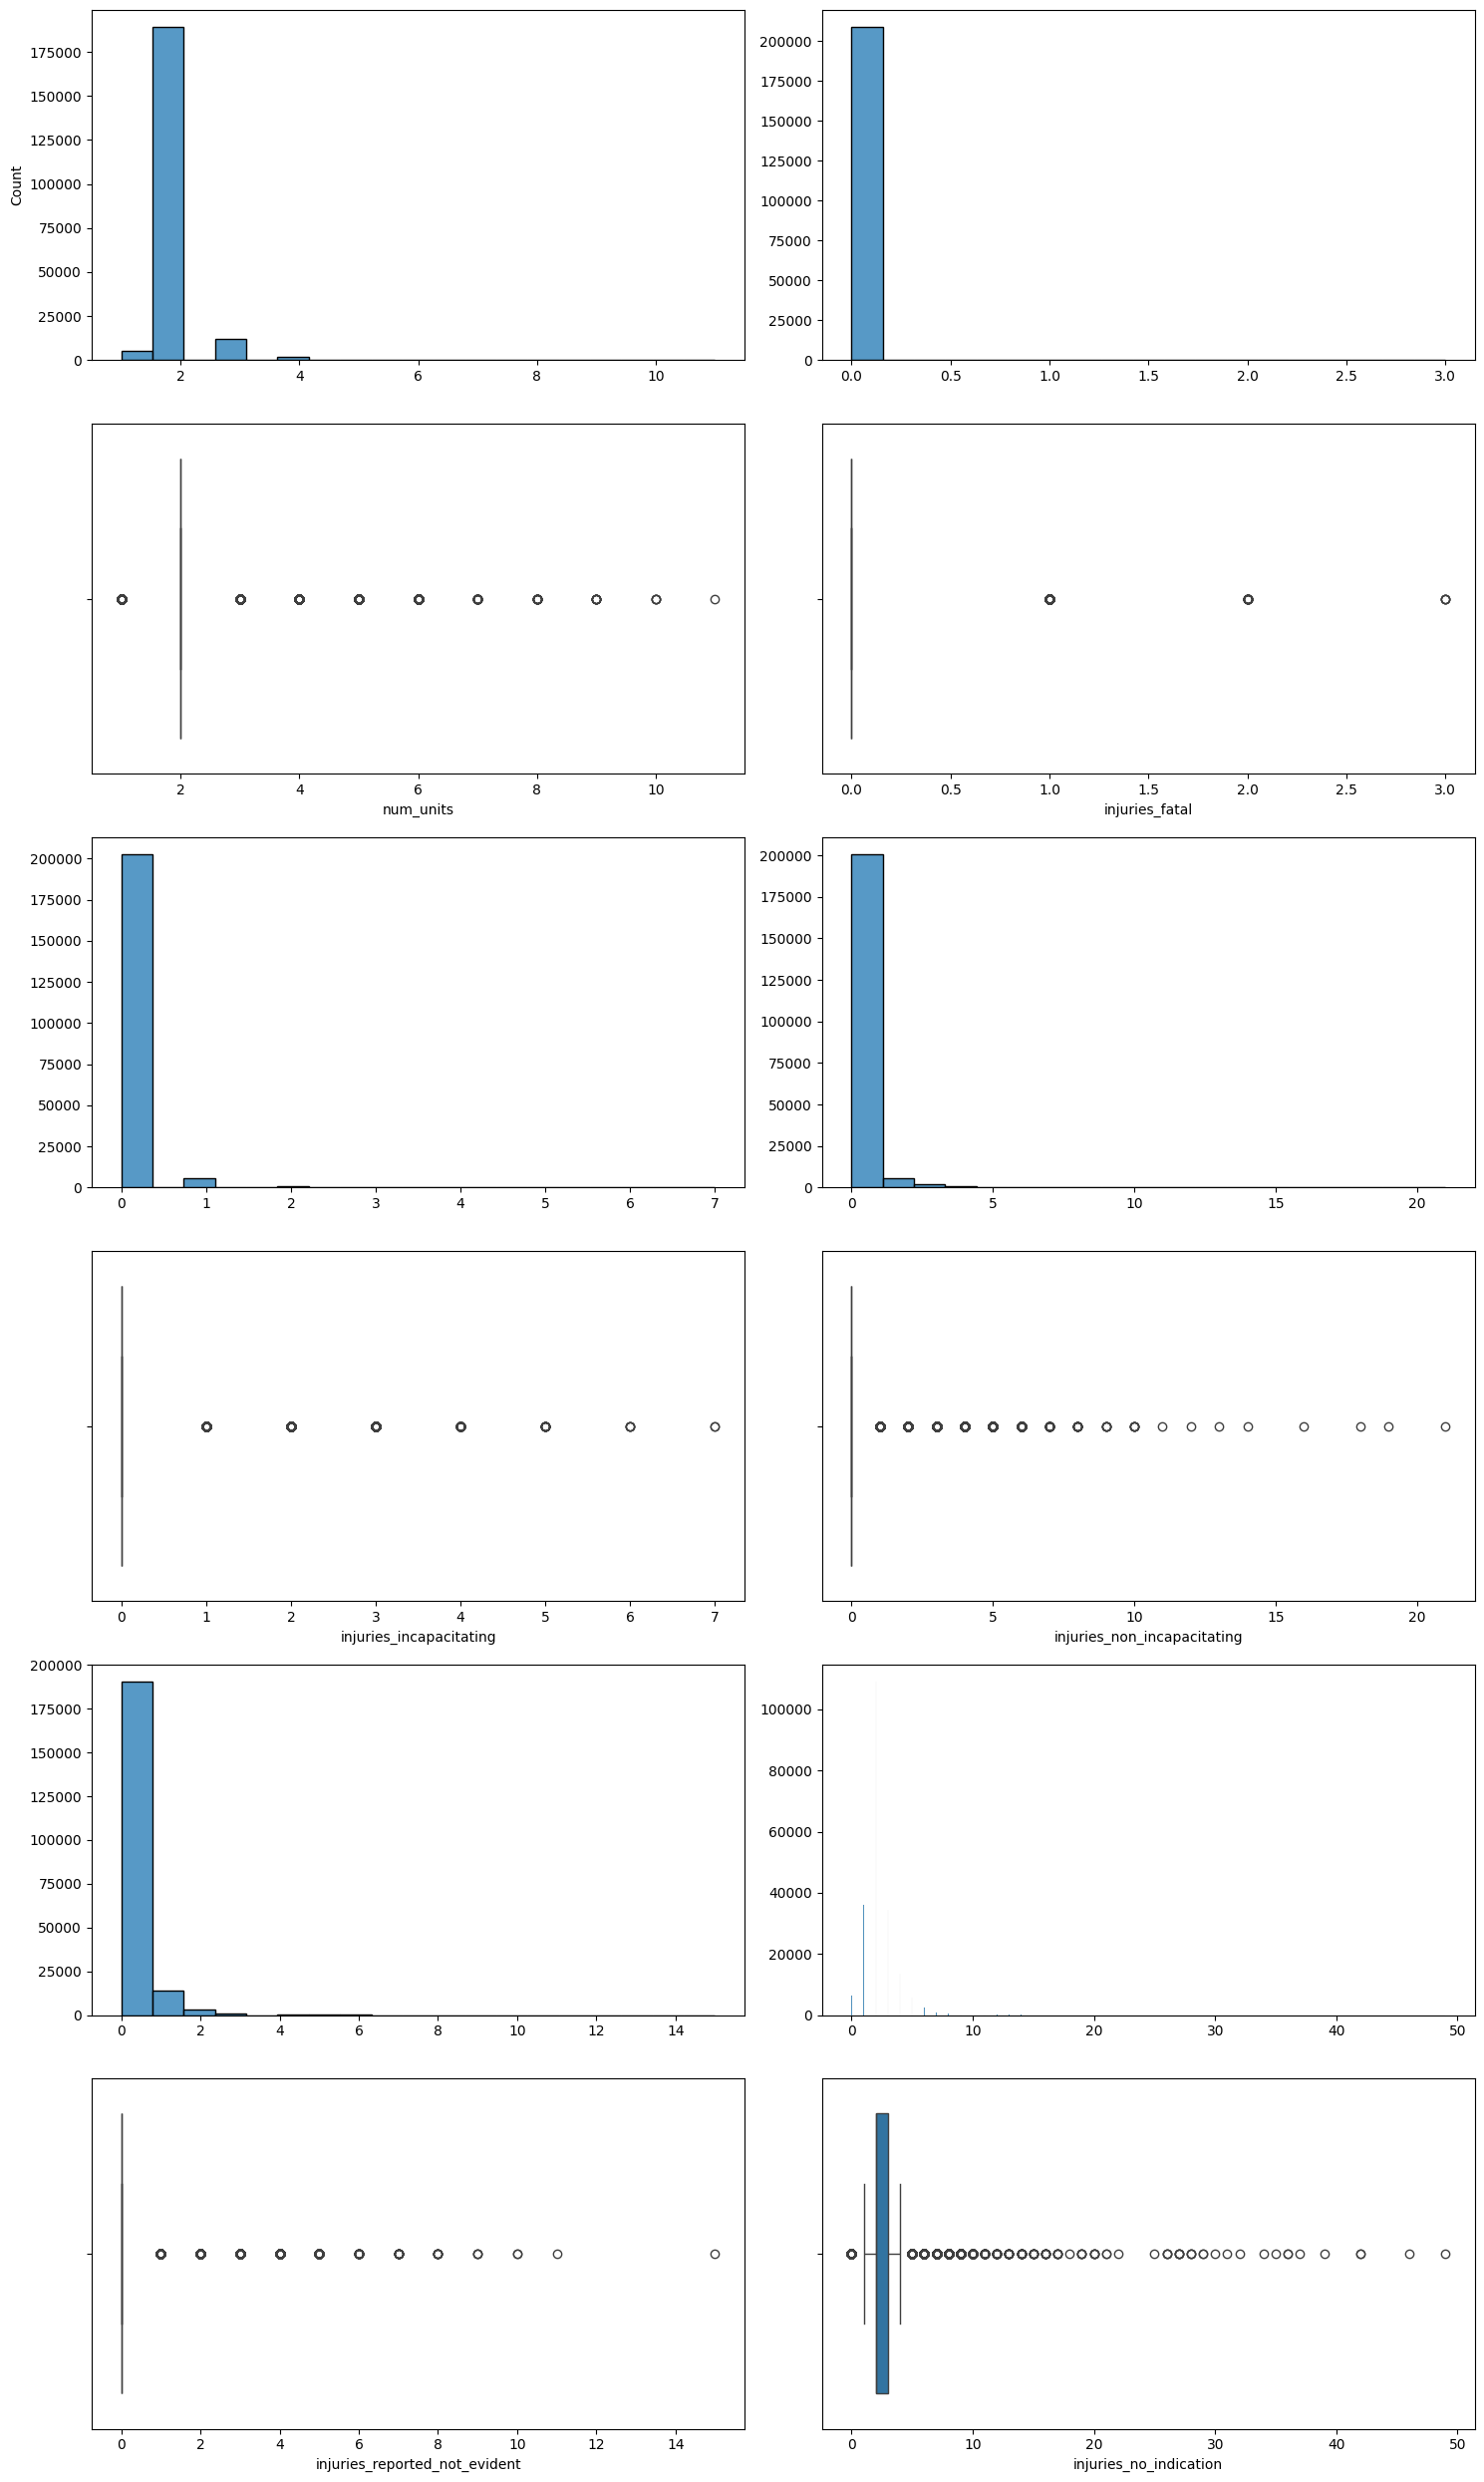

In [29]:
fig, axis = plt.subplots(6, 2, figsize = (15, 25))

# Creating a multiple figure with histograms and box plots
sns.histplot(ax = axis[0, 0], data = data, x = "num_units").set(xlabel = None)
sns.boxplot(ax = axis[1, 0], data = data, x = "num_units")
sns.histplot(ax = axis[0, 1], data = data, x = "injuries_fatal").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[1, 1], data = data, x = "injuries_fatal")
sns.histplot(ax = axis[2, 0], data = data, x = "injuries_incapacitating").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 0], data = data, x = "injuries_incapacitating")
sns.histplot(ax = axis[2, 1], data = data, x = "injuries_non_incapacitating").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[3, 1], data = data, x = "injuries_non_incapacitating")
sns.histplot(ax = axis[4, 0], data = data, x = "injuries_reported_not_evident").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 0], data = data, x = "injuries_reported_not_evident")
sns.histplot(ax = axis[4, 1], data = data, x = "injuries_no_indication").set(xlabel = None, ylabel = None)
sns.boxplot(ax = axis[5, 1], data = data, x = "injuries_no_indication")

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Agregar explicación del porqué se consideran numéricas

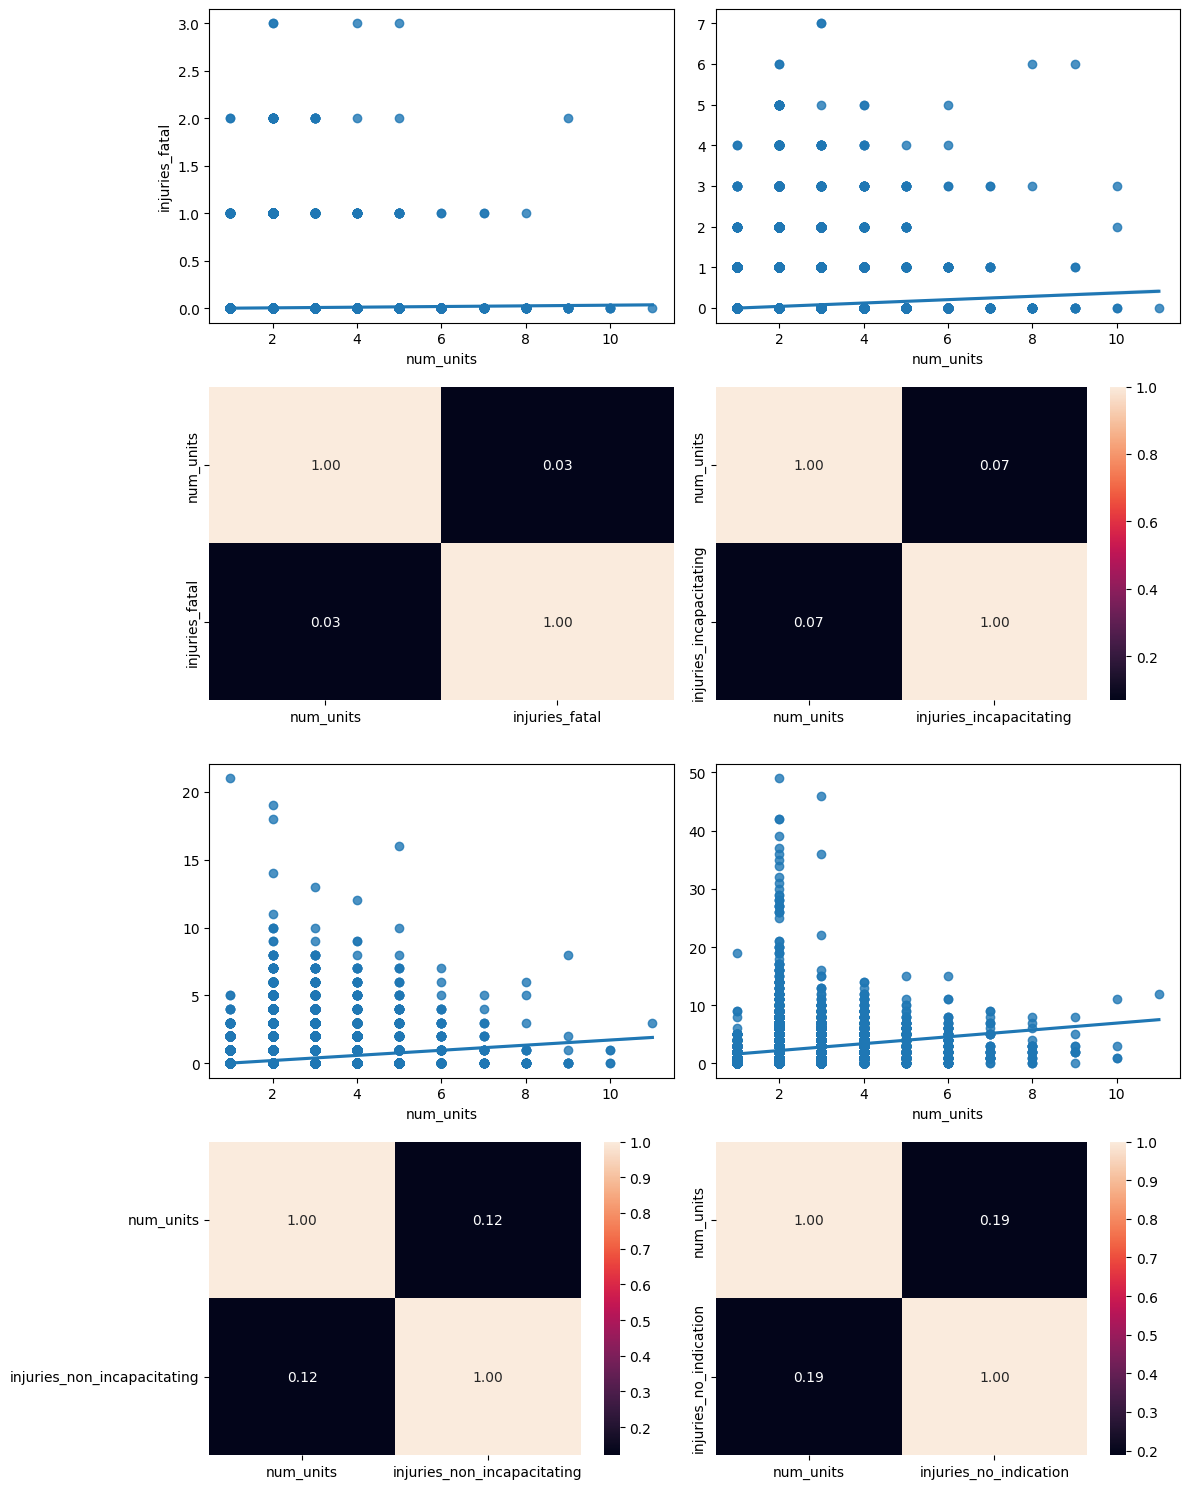

In [30]:
fig, axis = plt.subplots(4, 2, figsize = (12, 15))

# Create a multiple scatter diagram
sns.regplot(ax = axis[0, 0], data = data, x = "num_units", y = "injuries_fatal")
sns.heatmap(data[["num_units", "injuries_fatal"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = data, x = "num_units", y = "injuries_incapacitating").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_incapacitating"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])
sns.regplot(ax = axis[2, 0], data = data, x = "num_units", y = "injuries_non_incapacitating").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_non_incapacitating"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])
sns.regplot(ax = axis[2, 1], data = data, x = "num_units", y = "injuries_no_indication").set(ylabel=None)
sns.heatmap(data[["num_units", "injuries_no_indication"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Según los gráficos generados, no existe ninguna relación de peso entre las variables num_units e injuries (fatal, incapacitatin, non_incapacitating, no_indication). El valor más alto se obtiene con num_units y injuries_no_indication, pero se considera insuficiente para establecer una relación de valor.

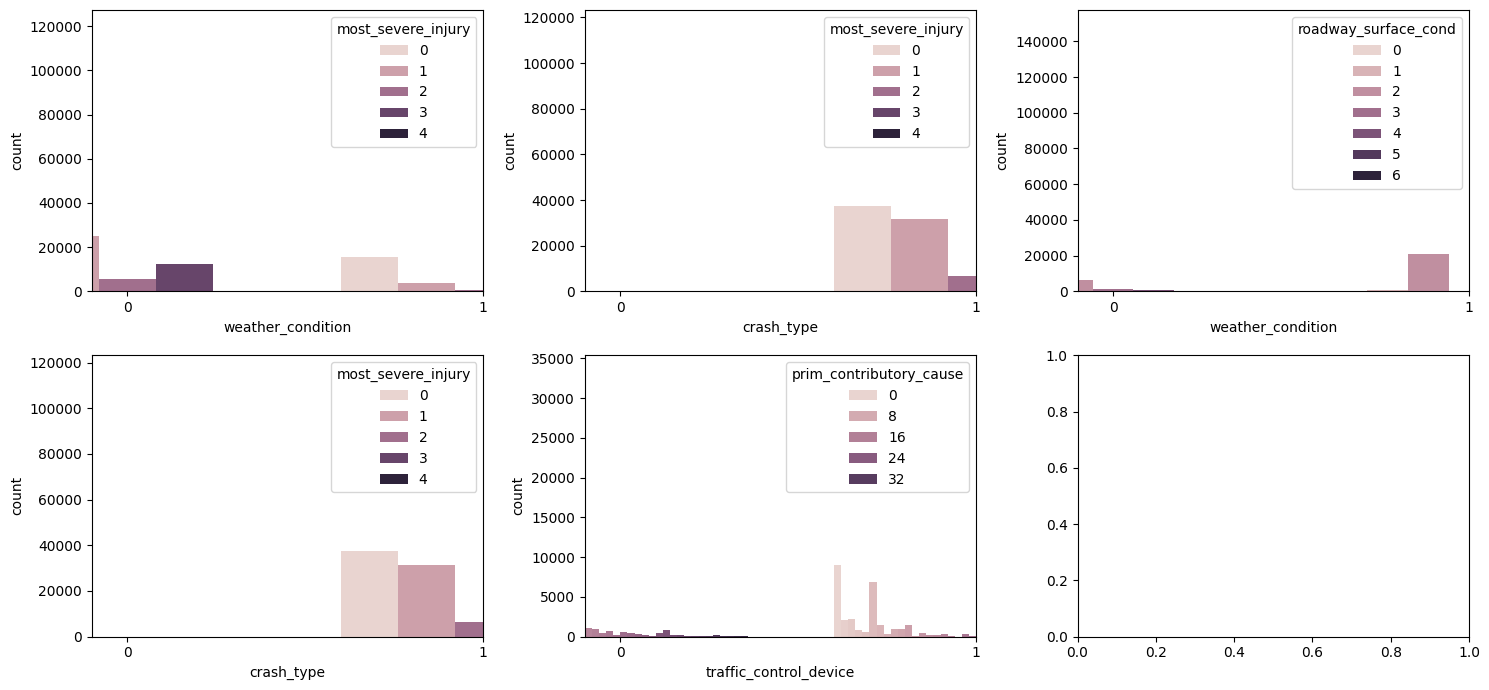

In [39]:
fig, axis = plt.subplots(2, 3, figsize = (15, 7))

sns.countplot(ax = axis[0, 0], data = data, x = "weather_condition", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[0, 1], data = data, x = "crash_type", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[0, 2], data = data, x = "weather_condition", hue = "roadway_surface_cond").set_xlim(-0.1, 1)
sns.countplot(ax = axis[1, 0], data = data, x = "crash_type", hue = "most_severe_injury").set_xlim(-0.1, 1)
sns.countplot(ax = axis[1, 1], data = data, x = "traffic_control_device", hue = "prim_contributory_cause").set_xlim(-0.1, 1)

plt.tight_layout()

#fig.delaxes(axis[1, 2])

plt.show()


/tmp/ipykernel_625/2923313382.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


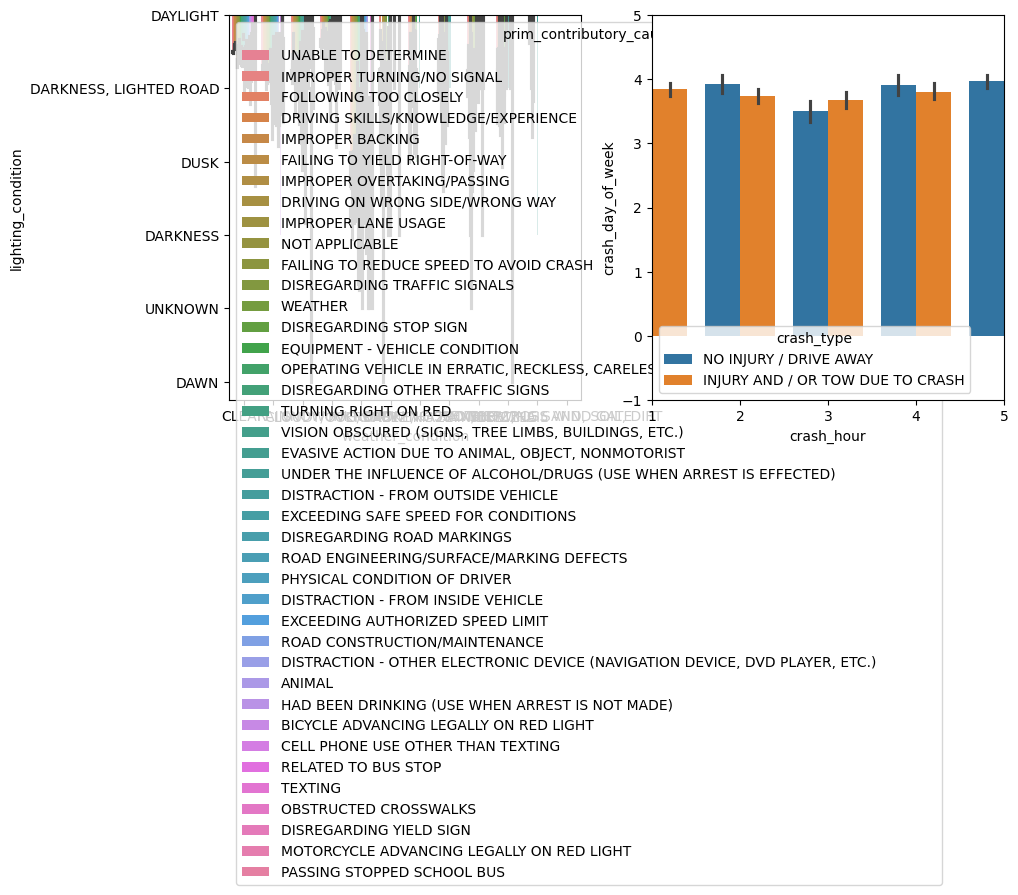

In [32]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 2)

sns.barplot(ax = axis[0], data = data, x = "weather_condition", y = "lighting_condition",hue = "prim_contributory_cause")
plt.xlim(1,5)
plt.ylim(-1,5)
sns.barplot(ax = axis[1], data = data, x = "crash_hour", y = "crash_day_of_week", hue = "crash_type")

plt.tight_layout()
plt.xlim(1,5)
plt.ylim(-1,5)
plt.show()

In [33]:
#Factorización de las variables categoricas
import pandas as pd

cols = data.select_dtypes(include=object)
cols = cols.columns

for x in cols:
    data[x] = pd.factorize(data[x])[0]



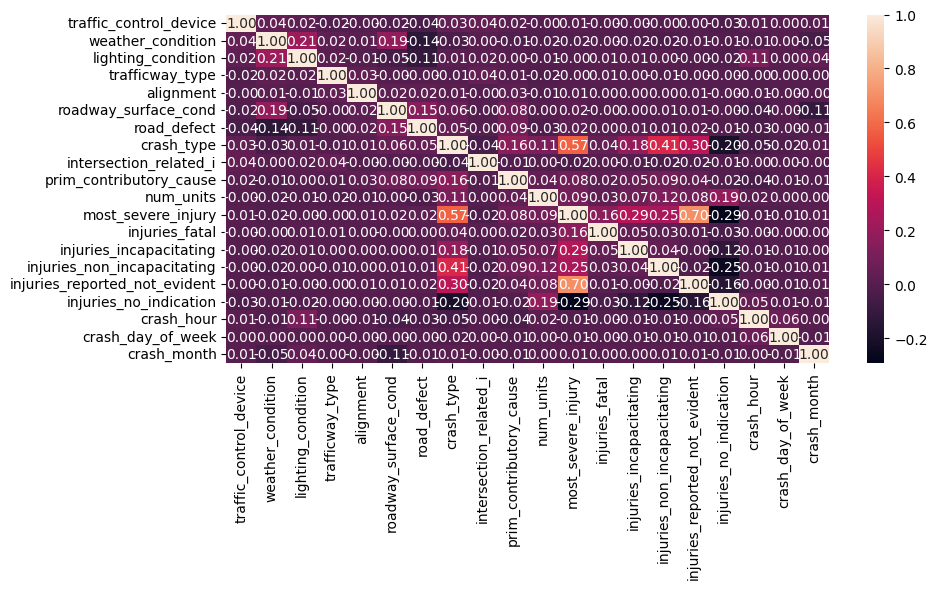

In [34]:
fig, axis = plt.subplots(figsize = (10, 6))

cols = data.columns
sns.heatmap(data[cols].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

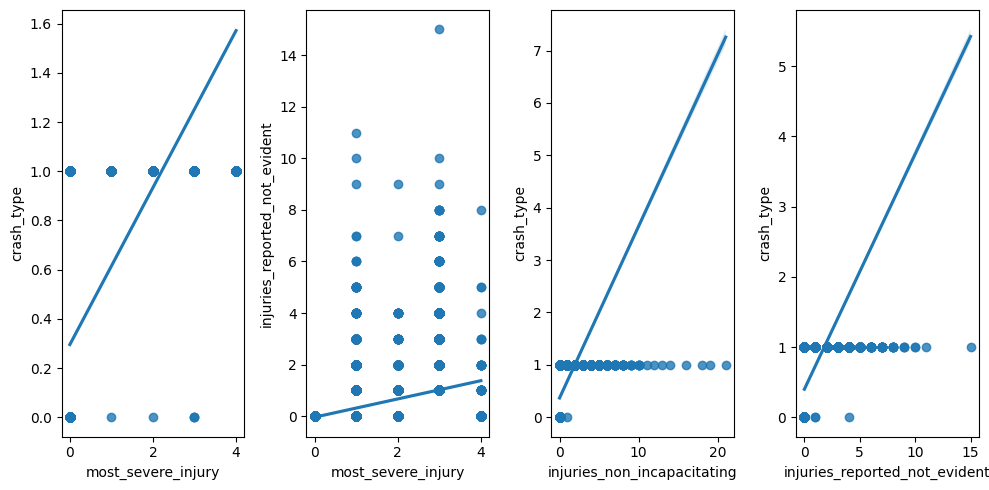

In [38]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 4)

sns.regplot(ax = axis[0], data = data, x = "most_severe_injury", y = "crash_type")
sns.regplot(ax = axis[1], data = data, x = "most_severe_injury", y = "injuries_reported_not_evident")
sns.regplot(ax = axis[2], data = data, x = "injuries_non_incapacitating", y = "crash_type")
sns.regplot(ax = axis[3], data = data, x = "injuries_reported_not_evident", y = "crash_type")

plt.tight_layout()

plt.show()
